# Variance Model

Inspired by: https://codeocean.com/capsule/2426768/tree/v2


In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import torch
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error


def load_and_merge_data():
    main_df = pd.read_csv("../beep_main_ds.csv")

    secondary_df = pd.read_csv("../test_secondary_beep_dataset.csv")

    df = pd.concat([main_df, secondary_df], ignore_index=True)
    return df


@dataclass
class CycleData:
    cycle_number: int
    voltage_in_V: List[float]
    current_in_A: List[float]
    charge_capacity_in_Ah: List[float]
    discharge_capacity_in_Ah: List[float]
    time_in_s: List[float]
    temperature_in_C: List[float]
    internal_resistance_in_ohm: Optional[float] = None
    additional_data: Dict = None


class BatteryData:
    def __init__(self, cell_id, cycle_data, max_voltage_limit_in_V, min_voltage_limit_in_V):
        self.cell_id = cell_id
        self.cycle_data = cycle_data
        self.max_voltage_limit_in_V = max_voltage_limit_in_V
        self.min_voltage_limit_in_V = min_voltage_limit_in_V


class VarianceModelFeatureExtractor:
    def __init__(self, critical_cycles=None):
        self.critical_cycles = critical_cycles or [1, 9, 99]
        self.interp_dims = 1000
        self.smooth_diff_qdlin = True
        self.use_precalculated_qdlin = False

    def get_Qdlin(self, cell_data, cycle_data):
        eps = 1e-1
        I = np.array(cycle_data.current_in_A)
        V = np.array(cycle_data.voltage_in_V)
        Q = np.array(cycle_data.discharge_capacity_in_Ah)

        mask = I < -eps
        if sum(mask) <= 2:
            return np.zeros(1000)

        # Interpolate
        from scipy.interpolate import interp1d

        func = interp1d(V[mask], Q[mask], bounds_error=False)
        new_x = np.linspace(
            cell_data.min_voltage_limit_in_V, cell_data.max_voltage_limit_in_V, 1000
        )
        return func(new_x)[::-1]

    def get_features(self, cell_data):
        early_cycle = cell_data.cycle_data[self.critical_cycles[1]]
        late_cycle = cell_data.cycle_data[self.critical_cycles[2]]

        early_qdlin = self.get_Qdlin(cell_data, early_cycle)
        late_qdlin = self.get_Qdlin(cell_data, late_cycle)

        diff_qdlin = late_qdlin - early_qdlin
        diff_qdlin = torch.from_numpy(diff_qdlin)
        diff_qdlin = diff_qdlin[~diff_qdlin.isnan()]

        if len(diff_qdlin) <= 1:
            return torch.tensor([0.0])

        eps = 1e-8
        variance = (diff_qdlin.var() + eps).log10()

        return variance.unsqueeze(0)


def convert_df_to_battery_data(df):
    battery_data_list = []

    for cell_key, cell_df in df.groupby("cell_key"):
        cycle_data_list = []

        for _, cycle_group in cell_df.groupby("cycle_number"):
            cycle_data = CycleData(
                cycle_number=int(cycle_group["cycle_number"].iloc[0]),
                voltage_in_V=cycle_group["voltage"].tolist(),
                current_in_A=cycle_group["current"].tolist(),
                charge_capacity_in_Ah=cycle_group["charge_capacity"].tolist(),
                discharge_capacity_in_Ah=cycle_group["discharge_capacity"].tolist(),
                time_in_s=cycle_group["time"].tolist(),
                temperature_in_C=cycle_group["temperature"].tolist(),
                additional_data={"Qdlin": None},
            )
            cycle_data_list.append(cycle_data)

        battery = BatteryData(
            cell_id=cell_key,
            cycle_data=cycle_data_list,
            max_voltage_limit_in_V=4.2,
            min_voltage_limit_in_V=2.0,
        )
        battery_data_list.append(battery)

    return battery_data_list


def train_model_with_split(df, train_cells, test_cells):
    """Train model with specific train/test split"""

    train_df = df[df["cell_key"].isin(train_cells)]
    test_df = df[df["cell_key"].isin(test_cells)]

    train_battery_data = convert_df_to_battery_data(train_df)
    test_battery_data = convert_df_to_battery_data(test_df)

    feature_extractor = VarianceModelFeatureExtractor()

    train_features = []
    train_cycle_lives = []
    test_features = []
    test_cycle_lives = []

    for battery in train_battery_data:
        feature = feature_extractor.get_features(battery)
        if not torch.isnan(feature).any():
            train_features.append(feature)
            train_cycle_lives.append(battery.cycle_data[-1].cycle_number)

    for battery in test_battery_data:
        feature = feature_extractor.get_features(battery)
        if not torch.isnan(feature).any():
            test_features.append(feature)
            test_cycle_lives.append(battery.cycle_data[-1].cycle_number)

    X_train = torch.stack(train_features)
    y_train = torch.tensor(train_cycle_lives)
    X_test = torch.stack(test_features)
    y_test = torch.tensor(test_cycle_lives)

    model = LinearRegression()
    model.fit(X_train.numpy(), y_train.numpy())

    train_pred = model.predict(X_train.numpy())
    test_pred = model.predict(X_test.numpy())

    train_rmse = np.sqrt(np.mean((train_pred - y_train.numpy()) ** 2))
    test_rmse = np.sqrt(np.mean((test_pred - y_test.numpy()) ** 2))
    train_mpe = np.mean(np.abs(train_pred - y_train.numpy()) / y_train.numpy() * 100)
    test_mpe = np.mean(np.abs(test_pred - y_test.numpy()) / y_test.numpy() * 100)
    train_mape = mean_absolute_percentage_error(y_train, train_pred) * 100
    test_mape = mean_absolute_percentage_error(y_test, test_pred) * 100
    return {
        "model": model,
        "metrics": {
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
            "train_mpe": train_mpe,
            "test_mpe": test_mpe,
            "train_mape": train_mape,
            "test_mape": test_mape,
        },
    }


def get_cell_splits():
    """Return the train/test splits for each model"""
    splits = {
        "model1": {
            "train": [
                "b2c0",
                "b2c1",
                "b2c10",
                "b2c11",
                "b2c12",
                "b2c13",
                "b2c14",
                "b2c17",
                "b2c18",
                "b2c19",
                "b2c2",
                "b2c20",
                "b2c21",
                "b2c22",
                "b2c23",
                "b2c24",
                "b2c25",
                "b2c26",
                "b2c27",
                "b2c28",
                "b2c29",
                "b2c3",
                "b2c30",
                "b2c31",
                "b2c32",
                "b2c33",
                "b2c34",
                "b2c35",
                "b2c36",
                "b2c37",
                "b2c38",
                "b2c39",
                "b2c4",
                "b2c40",
                "b2c41",
                "b2c42",
                "b2c43",
                "b2c44",
                "b2c45",
                "b2c46",
                "b2c47",
                "b2c5",
                "b2c6",
                "b3c0",
                "b3c1",
                "b3c10",
                "b3c11",
                "b3c12",
                "b3c13",
                "b3c14",
                "b3c15",
                "b3c16",
                "b3c17",
                "b3c18",
                "b3c19",
                "b3c20",
                "b3c21",
                "b3c22",
                "b3c24",
                "b3c25",
                "b3c26",
                "b3c27",
                "b3c28",
                "b3c29",
                "b3c3",
                "b3c30",
                "b3c31",
                "b3c33",
                "b3c34",
                "b3c35",
                "b3c36",
                "b3c38",
                "b3c39",
                "b3c4",
                "b3c40",
                "b3c41",
                "b3c44",
                "b3c45",
                "b3c5",
                "b3c6",
                "b3c7",
                "b3c8",
                "b3c9",
                "b5cl0",
                "b5cl1",
                "b5cl10",
                "b5cl11",
                "b5cl12",
                "b5cl13",
                "b5cl14",
                "b5cl15",
                "b5cl16",
                "b5cl17",
                "b5cl18",
                "b5cl19",
                "b5cl2",
                "b5cl20",
                "b5cl21",
                "b5cl22",
                "b5cl23",
                "b5cl24",
                "b5cl25",
                "b5cl26",
                "b5cl27",
                "b5cl28",
                "b5cl29",
                "b5cl3",
                "b5cl30",
                "b5cl31",
                "b5cl32",
                "b5cl33",
                "b5cl34",
                "b5cl35",
                "b5cl36",
                "b5cl37",
                "b5cl38",
                "b5cl39",
                "b5cl4",
                "b5cl40",
                "b5cl41",
                "b5cl42",
                "b5cl43",
                "b5cl44",
                "b5cl5",
                "b5cl6",
                "b5cl7",
                "b5cl8",
                "b5cl9",
            ],
            "test": [
                "b1c0",
                "b1c1",
                "b1c11",
                "b1c14",
                "b1c15",
                "b1c16",
                "b1c17",
                "b1c18",
                "b1c19",
                "b1c2",
                "b1c20",
                "b1c21",
                "b1c23",
                "b1c24",
                "b1c25",
                "b1c26",
                "b1c27",
                "b1c28",
                "b1c29",
                "b1c3",
                "b1c30",
                "b1c31",
                "b1c32",
                "b1c33",
                "b1c34",
                "b1c35",
                "b1c36",
                "b1c37",
                "b1c38",
                "b1c39",
                "b1c4",
                "b1c40",
                "b1c41",
                "b1c42",
                "b1c43",
                "b1c44",
                "b1c45",
                "b1c5",
                "b1c6",
                "b1c7",
                "b1c9",
            ],
        },
        "model2": {
            "train": [
                "b1c0",
                "b1c1",
                "b1c11",
                "b1c14",
                "b1c15",
                "b1c16",
                "b1c17",
                "b1c18",
                "b1c19",
                "b1c2",
                "b1c20",
                "b1c21",
                "b1c23",
                "b1c24",
                "b1c25",
                "b1c26",
                "b1c27",
                "b1c28",
                "b1c29",
                "b1c3",
                "b1c30",
                "b1c31",
                "b1c32",
                "b1c33",
                "b1c34",
                "b1c35",
                "b1c36",
                "b1c37",
                "b1c38",
                "b1c39",
                "b1c4",
                "b1c40",
                "b1c41",
                "b1c42",
                "b1c43",
                "b1c44",
                "b1c45",
                "b1c5",
                "b1c6",
                "b1c7",
                "b1c9",
                "b3c0",
                "b3c1",
                "b3c10",
                "b3c11",
                "b3c12",
                "b3c13",
                "b3c14",
                "b3c15",
                "b3c16",
                "b3c17",
                "b3c18",
                "b3c19",
                "b3c20",
                "b3c21",
                "b3c22",
                "b3c24",
                "b3c25",
                "b3c26",
                "b3c27",
                "b3c28",
                "b3c29",
                "b3c3",
                "b3c30",
                "b3c31",
                "b3c33",
                "b3c34",
                "b3c35",
                "b3c36",
                "b3c38",
                "b3c39",
                "b3c4",
                "b3c40",
                "b3c41",
                "b3c44",
                "b3c45",
                "b3c5",
                "b3c6",
                "b3c7",
                "b3c8",
                "b3c9",
                "b5cl0",
                "b5cl1",
                "b5cl10",
                "b5cl11",
                "b5cl12",
                "b5cl13",
                "b5cl14",
                "b5cl15",
                "b5cl16",
                "b5cl17",
                "b5cl18",
                "b5cl19",
                "b5cl2",
                "b5cl20",
                "b5cl21",
                "b5cl22",
                "b5cl23",
                "b5cl24",
                "b5cl25",
                "b5cl26",
                "b5cl27",
                "b5cl28",
                "b5cl29",
                "b5cl3",
                "b5cl30",
                "b5cl31",
                "b5cl32",
                "b5cl33",
                "b5cl34",
                "b5cl35",
                "b5cl36",
                "b5cl37",
                "b5cl38",
                "b5cl39",
                "b5cl4",
                "b5cl40",
                "b5cl41",
                "b5cl42",
                "b5cl43",
                "b5cl44",
                "b5cl5",
                "b5cl6",
                "b5cl7",
                "b5cl8",
                "b5cl9",
            ],
            "test": [
                "b2c0",
                "b2c1",
                "b2c10",
                "b2c11",
                "b2c12",
                "b2c13",
                "b2c14",
                "b2c17",
                "b2c18",
                "b2c19",
                "b2c2",
                "b2c20",
                "b2c21",
                "b2c22",
                "b2c23",
                "b2c24",
                "b2c25",
                "b2c26",
                "b2c27",
                "b2c28",
                "b2c29",
                "b2c3",
                "b2c30",
                "b2c31",
                "b2c32",
                "b2c33",
                "b2c34",
                "b2c35",
                "b2c36",
                "b2c37",
                "b2c38",
                "b2c39",
                "b2c4",
                "b2c40",
                "b2c41",
                "b2c42",
                "b2c43",
                "b2c44",
                "b2c45",
                "b2c46",
                "b2c47",
                "b2c5",
                "b2c6",
            ],
        },
        "model3": {
            "train": [
                "b1c0",
                "b1c1",
                "b1c11",
                "b1c14",
                "b1c15",
                "b1c16",
                "b1c17",
                "b1c18",
                "b1c19",
                "b1c2",
                "b1c20",
                "b1c21",
                "b1c23",
                "b1c24",
                "b1c25",
                "b1c26",
                "b1c27",
                "b1c28",
                "b1c29",
                "b1c3",
                "b1c30",
                "b1c31",
                "b1c32",
                "b1c33",
                "b1c34",
                "b1c35",
                "b1c36",
                "b1c37",
                "b1c38",
                "b1c39",
                "b1c4",
                "b1c40",
                "b1c41",
                "b1c42",
                "b1c43",
                "b1c44",
                "b1c45",
                "b1c5",
                "b1c6",
                "b1c7",
                "b1c9",
                "b2c0",
                "b2c1",
                "b2c10",
                "b2c11",
                "b2c12",
                "b2c13",
                "b2c14",
                "b2c17",
                "b2c18",
                "b2c19",
                "b2c2",
                "b2c20",
                "b2c21",
                "b2c22",
                "b2c23",
                "b2c24",
                "b2c25",
                "b2c26",
                "b2c27",
                "b2c28",
                "b2c29",
                "b2c3",
                "b2c30",
                "b2c31",
                "b2c32",
                "b2c33",
                "b2c34",
                "b2c35",
                "b2c36",
                "b2c37",
                "b2c38",
                "b2c39",
                "b2c4",
                "b2c40",
                "b2c41",
                "b2c42",
                "b2c43",
                "b2c44",
                "b2c45",
                "b2c46",
                "b2c47",
                "b2c5",
                "b2c6",
                "b5cl0",
                "b5cl1",
                "b5cl10",
                "b5cl11",
                "b5cl12",
                "b5cl13",
                "b5cl14",
                "b5cl15",
                "b5cl16",
                "b5cl17",
                "b5cl18",
                "b5cl19",
                "b5cl2",
                "b5cl20",
                "b5cl21",
                "b5cl22",
                "b5cl23",
                "b5cl24",
                "b5cl25",
                "b5cl26",
                "b5cl27",
                "b5cl28",
                "b5cl29",
                "b5cl3",
                "b5cl30",
                "b5cl31",
                "b5cl32",
                "b5cl33",
                "b5cl34",
                "b5cl35",
                "b5cl36",
                "b5cl37",
                "b5cl38",
                "b5cl39",
                "b5cl4",
                "b5cl40",
                "b5cl41",
                "b5cl42",
                "b5cl43",
                "b5cl44",
                "b5cl5",
                "b5cl6",
                "b5cl7",
                "b5cl8",
                "b5cl9",
            ],
            "test": [
                "b3c0",
                "b3c1",
                "b3c10",
                "b3c11",
                "b3c12",
                "b3c13",
                "b3c14",
                "b3c15",
                "b3c16",
                "b3c17",
                "b3c18",
                "b3c19",
                "b3c20",
                "b3c21",
                "b3c22",
                "b3c24",
                "b3c25",
                "b3c26",
                "b3c27",
                "b3c28",
                "b3c29",
                "b3c3",
                "b3c30",
                "b3c31",
                "b3c33",
                "b3c34",
                "b3c35",
                "b3c36",
                "b3c38",
                "b3c39",
                "b3c4",
                "b3c40",
                "b3c41",
                "b3c44",
                "b3c45",
                "b3c5",
                "b3c6",
                "b3c7",
                "b3c8",
                "b3c9",
            ],
        },
        "model4": {
            "train": [
                "b1c0",
                "b1c1",
                "b1c11",
                "b1c14",
                "b1c15",
                "b1c16",
                "b1c17",
                "b1c18",
                "b1c19",
                "b1c2",
                "b1c20",
                "b1c21",
                "b1c23",
                "b1c24",
                "b1c25",
                "b1c26",
                "b1c27",
                "b1c28",
                "b1c29",
                "b1c3",
                "b1c30",
                "b1c31",
                "b1c32",
                "b1c33",
                "b1c34",
                "b1c35",
                "b1c36",
                "b1c37",
                "b1c38",
                "b1c39",
                "b1c4",
                "b1c40",
                "b1c41",
                "b1c42",
                "b1c43",
                "b1c44",
                "b1c45",
                "b1c5",
                "b1c6",
                "b1c7",
                "b1c9",
                "b2c0",
                "b2c1",
                "b2c10",
                "b2c11",
                "b2c12",
                "b2c13",
                "b2c14",
                "b2c17",
                "b2c18",
                "b2c19",
                "b2c2",
                "b2c20",
                "b2c21",
                "b2c22",
                "b2c23",
                "b2c24",
                "b2c25",
                "b2c26",
                "b2c27",
                "b2c28",
                "b2c29",
                "b2c3",
                "b2c30",
                "b2c31",
                "b2c32",
                "b2c33",
                "b2c34",
                "b2c35",
                "b2c36",
                "b2c37",
                "b2c38",
                "b2c39",
                "b2c4",
                "b2c40",
                "b2c41",
                "b2c42",
                "b2c43",
                "b2c44",
                "b2c45",
                "b2c46",
                "b2c47",
                "b2c5",
                "b2c6",
                "b3c0",
                "b3c1",
                "b3c10",
                "b3c11",
                "b3c12",
                "b3c13",
                "b3c14",
                "b3c15",
                "b3c16",
                "b3c17",
                "b3c18",
                "b3c19",
                "b3c20",
                "b3c21",
                "b3c22",
                "b3c24",
                "b3c25",
                "b3c26",
                "b3c27",
                "b3c28",
                "b3c29",
                "b3c3",
                "b3c30",
                "b3c31",
                "b3c33",
                "b3c34",
                "b3c35",
                "b3c36",
                "b3c38",
                "b3c39",
                "b3c4",
                "b3c40",
                "b3c41",
                "b3c44",
                "b3c45",
                "b3c5",
                "b3c6",
                "b3c7",
                "b3c8",
                "b3c9",
            ],
            "test": [
                "b5cl0",
                "b5cl1",
                "b5cl10",
                "b5cl11",
                "b5cl12",
                "b5cl13",
                "b5cl14",
                "b5cl15",
                "b5cl16",
                "b5cl17",
                "b5cl18",
                "b5cl19",
                "b5cl2",
                "b5cl20",
                "b5cl21",
                "b5cl22",
                "b5cl23",
                "b5cl24",
                "b5cl25",
                "b5cl26",
                "b5cl27",
                "b5cl28",
                "b5cl29",
                "b5cl3",
                "b5cl30",
                "b5cl31",
                "b5cl32",
                "b5cl33",
                "b5cl34",
                "b5cl35",
                "b5cl36",
                "b5cl37",
                "b5cl38",
                "b5cl39",
                "b5cl4",
                "b5cl40",
                "b5cl41",
                "b5cl42",
                "b5cl43",
                "b5cl44",
                "b5cl5",
                "b5cl6",
                "b5cl7",
                "b5cl8",
                "b5cl9",
            ],
        },
        "model5": {
            "train": [
                "b1c0",
                "b1c11",
                "b1c16",
                "b1c17",
                "b1c18",
                "b1c2",
                "b1c20",
                "b1c21",
                "b1c23",
                "b1c24",
                "b1c25",
                "b1c26",
                "b1c3",
                "b1c30",
                "b1c32",
                "b1c35",
                "b1c36",
                "b1c37",
                "b1c38",
                "b1c39",
                "b1c4",
                "b1c41",
                "b1c43",
                "b2c0",
                "b2c1",
                "b2c11",
                "b2c13",
                "b2c14",
                "b2c17",
                "b2c18",
                "b2c2",
                "b2c24",
                "b2c25",
                "b2c27",
                "b2c28",
                "b2c29",
                "b2c3",
                "b2c30",
                "b2c33",
                "b2c36",
                "b2c38",
                "b2c39",
                "b2c4",
                "b2c40",
                "b2c41",
                "b2c42",
                "b2c45",
                "b2c46",
                "b2c47",
                "b2c6",
                "b3c1",
                "b3c11",
                "b3c12",
                "b3c13",
                "b3c16",
                "b3c17",
                "b3c18",
                "b3c19",
                "b3c20",
                "b3c21",
                "b3c27",
                "b3c29",
                "b3c30",
                "b3c34",
                "b3c35",
                "b3c36",
                "b3c39",
                "b3c41",
                "b3c45",
                "b3c6",
                "b3c9",
                "b5cl0",
                "b5cl1",
                "b5cl10",
                "b5cl11",
                "b5cl12",
                "b5cl13",
                "b5cl14",
                "b5cl16",
                "b5cl17",
                "b5cl18",
                "b5cl2",
                "b5cl20",
                "b5cl21",
                "b5cl22",
                "b5cl23",
                "b5cl24",
                "b5cl26",
                "b5cl28",
                "b5cl3",
                "b5cl31",
                "b5cl34",
                "b5cl35",
                "b5cl38",
                "b5cl4",
                "b5cl40",
                "b5cl43",
                "b5cl44",
                "b5cl6",
                "b5cl8",
                "b5cl9",
                "b1c14",
                "b1c19",
                "b1c34",
                "b1c42",
                "b1c5",
                "b2c10",
                "b2c22",
                "b2c32",
                "b2c37",
                "b2c43",
                "b2c44",
                "b2c5",
                "b3c0",
                "b3c15",
                "b3c22",
                "b3c24",
                "b3c28",
                "b3c31",
                "b3c38",
                "b3c40",
                "b3c44",
                "b3c7",
                "b5cl32",
                "b5cl41",
                "b5cl7",
            ],
            "test": [
                "b1c1",
                "b1c15",
                "b1c27",
                "b1c28",
                "b1c29",
                "b1c31",
                "b1c33",
                "b1c40",
                "b1c44",
                "b1c45",
                "b1c6",
                "b1c7",
                "b1c9",
                "b2c12",
                "b2c19",
                "b2c20",
                "b2c21",
                "b2c23",
                "b2c26",
                "b2c31",
                "b2c34",
                "b2c35",
                "b3c10",
                "b3c14",
                "b3c25",
                "b3c26",
                "b3c3",
                "b3c33",
                "b3c4",
                "b3c5",
                "b3c8",
                "b5cl15",
                "b5cl19",
                "b5cl25",
                "b5cl27",
                "b5cl29",
                "b5cl30",
                "b5cl33",
                "b5cl36",
                "b5cl37",
                "b5cl39",
                "b5cl42",
                "b5cl5",
            ],
        },
        "original_model_split": {
            "train": [
                "b1c0",
                "b1c2",
                "b1c4",
                "b1c6",
                "b1c9",
                "b1c14",
                "b1c16",
                "b1c18",
                "b1c20",
                "b1c23",
                "b1c25",
                "b1c27",
                "b1c29",
                "b1c31",
                "b1c33",
                "b1c35",
                "b1c37",
                "b1c39",
                "b1c41",
                "b1c43",
                "b1c45",
                "b2c1",
                "b2c3",
                "b2c5",
                "b2c10",
                "b2c12",
                "b2c14",
                "b2c18",
                "b2c20",
                "b2c22",
                "b2c24",
                "b2c26",
                "b2c28",
                "b2c30",
                "b2c32",
                "b2c34",
                "b2c36",
                "b2c38",
                "b2c40",
                "b2c42",
                "b2c44",
                "b2c46",
                "b2c47",
            ],
            "test": [
                "b1c1",
                "b1c3",
                "b1c5",
                "b1c7",
                "b1c11",
                "b1c15",
                "b1c17",
                "b1c19",
                "b1c21",
                "b1c24",
                "b1c26",
                "b1c28",
                "b1c30",
                "b1c32",
                "b1c34",
                "b1c36",
                "b1c38",
                "b1c40",
                "b1c42",
                "b1c44",
                "b2c0",
                "b2c2",
                "b2c4",
                "b2c6",
                "b2c11",
                "b2c13",
                "b2c17",
                "b2c19",
                "b2c21",
                "b2c23",
                "b2c25",
                "b2c27",
                "b2c29",
                "b2c31",
                "b2c33",
                "b2c35",
                "b2c37",
                "b2c39",
                "b2c41",
                "b2c43",
                "b2c45",
            ],
        },
        "model5Strat": {
            "train": [
                "b1c0",
                "b1c11",
                "b1c14",
                "b1c16",
                "b1c19",
                "b1c2",
                "b1c20",
                "b1c23",
                "b1c24",
                "b1c26",
                "b1c28",
                "b1c3",
                "b1c30",
                "b1c32",
                "b1c34",
                "b1c37",
                "b1c38",
                "b1c41",
                "b1c43",
                "b1c44",
                "b1c5",
                "b1c7",
                "b1c9",
                "b2c0",
                "b2c1",
                "b2c10",
                "b2c11",
                "b2c12",
                "b2c13",
                "b2c14",
                "b2c17",
                "b2c18",
                "b2c19",
                "b2c2",
                "b2c20",
                "b2c22",
                "b2c23",
                "b2c24",
                "b2c25",
                "b2c26",
                "b2c27",
                "b2c28",
                "b2c29",
                "b2c3",
                "b2c30",
                "b2c31",
                "b2c32",
                "b2c33",
                "b2c34",
                "b2c35",
                "b2c36",
                "b2c37",
                "b2c38",
                "b2c39",
                "b2c4",
                "b2c40",
                "b2c41",
                "b2c42",
                "b2c43",
                "b2c44",
                "b2c45",
                "b2c46",
                "b2c47",
                "b2c5",
                "b2c6",
                "b3c0",
                "b3c12",
                "b3c15",
                "b3c17",
                "b3c20",
                "b3c21",
                "b3c22",
                "b3c26",
                "b3c28",
                "b3c3",
                "b3c34",
                "b3c36",
                "b3c38",
                "b3c4",
                "b3c45",
                "b3c7",
                "b3c9",
                "b5cl0",
                "b5cl11",
                "b5cl12",
                "b5cl14",
                "b5cl17",
                "b5cl18",
                "b5cl19",
                "b5cl20",
                "b5cl22",
                "b5cl23",
                "b5cl25",
                "b5cl29",
                "b5cl32",
                "b5cl33",
                "b5cl34",
                "b5cl36",
                "b5cl4",
                "b5cl43",
                "b5cl6",
                "b5cl8",
            ],
            "test": [
                "b1c1",
                "b1c15",
                "b1c17",
                "b1c18",
                "b1c21",
                "b1c25",
                "b1c27",
                "b1c29",
                "b1c31",
                "b1c33",
                "b1c35",
                "b1c36",
                "b1c39",
                "b1c4",
                "b1c40",
                "b1c42",
                "b1c45",
                "b1c6",
                "b2c21",
                "b3c1",
                "b3c10",
                "b3c11",
                "b3c13",
                "b3c14",
                "b3c16",
                "b3c18",
                "b3c19",
                "b3c24",
                "b3c25",
                "b3c27",
                "b3c29",
                "b3c30",
                "b3c31",
                "b3c33",
                "b3c35",
                "b3c39",
                "b3c40",
                "b3c41",
                "b3c44",
                "b3c5",
                "b3c6",
                "b3c8",
                "b5cl1",
                "b5cl10",
                "b5cl13",
                "b5cl15",
                "b5cl16",
                "b5cl2",
                "b5cl21",
                "b5cl24",
                "b5cl26",
                "b5cl27",
                "b5cl28",
                "b5cl3",
                "b5cl30",
                "b5cl31",
                "b5cl35",
                "b5cl37",
                "b5cl38",
                "b5cl39",
                "b5cl40",
                "b5cl41",
                "b5cl42",
                "b5cl44",
                "b5cl5",
                "b5cl7",
                "b5cl9",
            ],
        },
    }

    return splits


def main():
    # Load and merge data
    df = load_and_merge_data()

    # Get splits
    splits = get_cell_splits()

    # Train models for each split
    results = {}
    for model_name, split in splits.items():
        print(f"\nTraining {model_name}...")
        model_results = train_model_with_split(df, split["train"], split["test"])
        results[model_name] = model_results["metrics"]
        print(f"Train RMSE: {model_results['metrics']['train_rmse']:.1f} cycles")
        print(f"Train MPE: {model_results['metrics']['train_mpe']:.1f}%")
        print(f"Train MAPE: {model_results['metrics']['train_mape']:.1f}%")
        print(f"Test RMSE: {model_results['metrics']['test_rmse']:.1f} cycles")
        print(f"Test MPE: {model_results['metrics']['test_mpe']:.1f}%")
        print(f"Test MAPE: {model_results['metrics']['test_mape']:.1f}%")

    return results


if __name__ == "__main__":
    main()


Training model1...
Train RMSE: 156.7 cycles
Train MPE: 13.7%
Train MAPE: 13.7%
Test RMSE: 225.3 cycles
Test MPE: 14.2%
Test MAPE: 14.2%

Training model2...
Train RMSE: 185.5 cycles
Train MPE: 14.4%
Train MAPE: 14.4%
Test RMSE: 130.9 cycles
Test MPE: 21.6%
Test MAPE: 21.6%

Training model3...
Train RMSE: 154.2 cycles
Train MPE: 15.1%
Train MAPE: 15.1%
Test RMSE: 222.1 cycles
Test MPE: 12.1%
Test MAPE: 12.1%

Training model4...
Train RMSE: 172.6 cycles
Train MPE: 16.8%
Train MAPE: 16.8%
Test RMSE: 198.4 cycles
Test MPE: 20.9%
Test MAPE: 20.9%

Training model5...
Train RMSE: 179.7 cycles
Train MPE: 15.5%
Train MAPE: 15.5%
Test RMSE: 144.0 cycles
Test MPE: 14.5%
Test MAPE: 14.5%

Training original_model_split...
Train RMSE: 155.9 cycles
Train MPE: 19.3%
Train MAPE: 19.3%
Test RMSE: 148.8 cycles
Test MPE: 18.8%
Test MAPE: 18.8%

Training model5Strat...
Train RMSE: 186.1 cycles
Train MPE: 17.5%
Train MAPE: 17.5%
Test RMSE: 148.8 cycles
Test MPE: 13.6%
Test MAPE: 13.6%



Training model1...


/var/folders/zd/ngy20k3s5ljf8rnfs165f6b40000gn/T/ipykernel_49205/1948138764.py:86: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Train RMSE: 156.7 cycles
Train MPE: 13.7%
Test RMSE: 225.3 cycles
Test MPE: 14.2%

Training model2...


/var/folders/zd/ngy20k3s5ljf8rnfs165f6b40000gn/T/ipykernel_49205/1948138764.py:86: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Train RMSE: 185.5 cycles
Train MPE: 14.4%
Test RMSE: 130.9 cycles
Test MPE: 21.6%

Training model3...


/var/folders/zd/ngy20k3s5ljf8rnfs165f6b40000gn/T/ipykernel_49205/1948138764.py:86: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Train RMSE: 154.2 cycles
Train MPE: 15.1%
Test RMSE: 222.1 cycles
Test MPE: 12.1%

Training model4...


/var/folders/zd/ngy20k3s5ljf8rnfs165f6b40000gn/T/ipykernel_49205/1948138764.py:86: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Train RMSE: 172.6 cycles
Train MPE: 16.8%
Test RMSE: 198.4 cycles
Test MPE: 20.9%

Training model5...
Train RMSE: 179.7 cycles
Train MPE: 15.5%
Test RMSE: 144.0 cycles
Test MPE: 14.5%


/var/folders/zd/ngy20k3s5ljf8rnfs165f6b40000gn/T/ipykernel_49205/1948138764.py:86: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


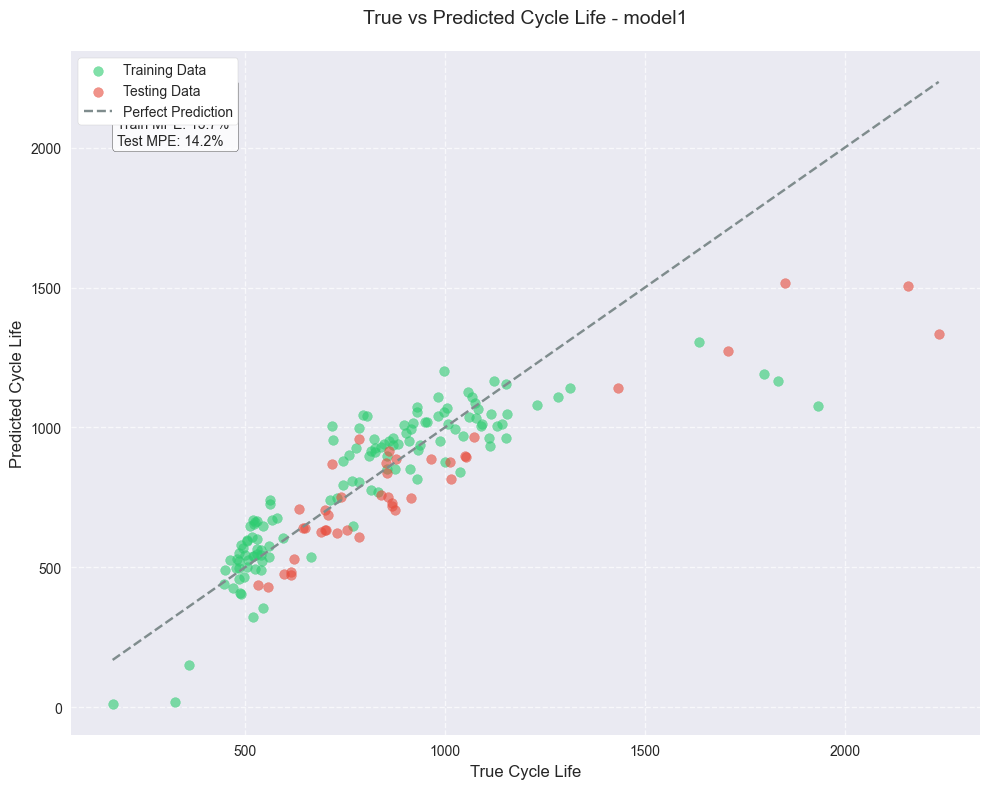

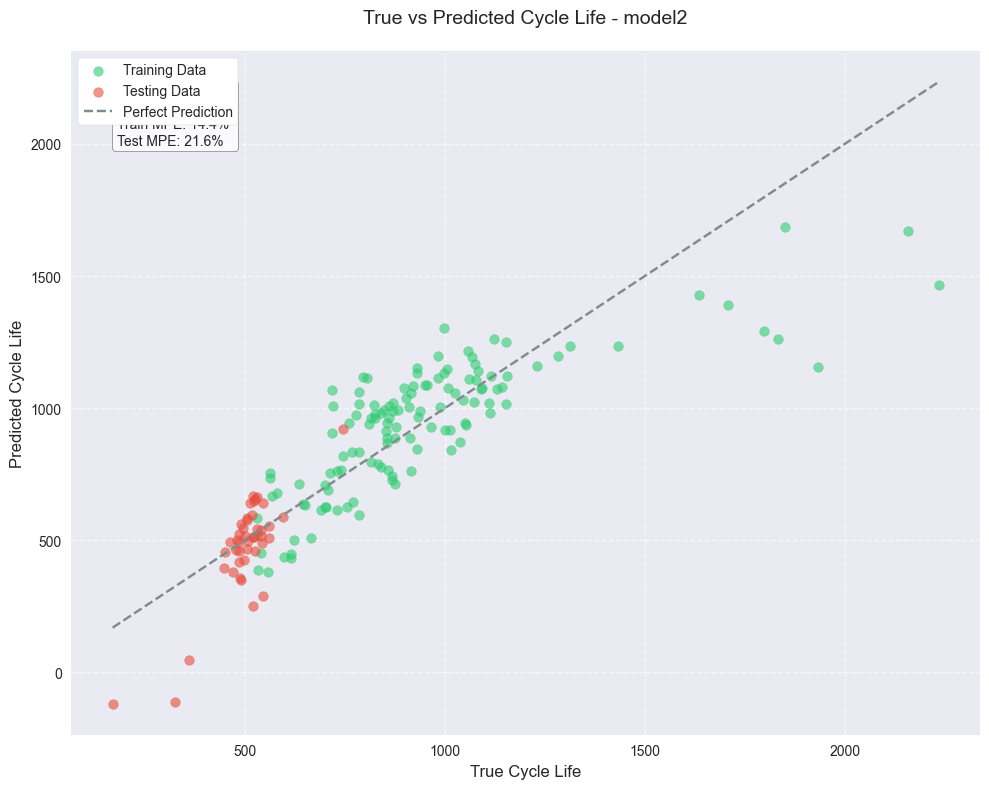

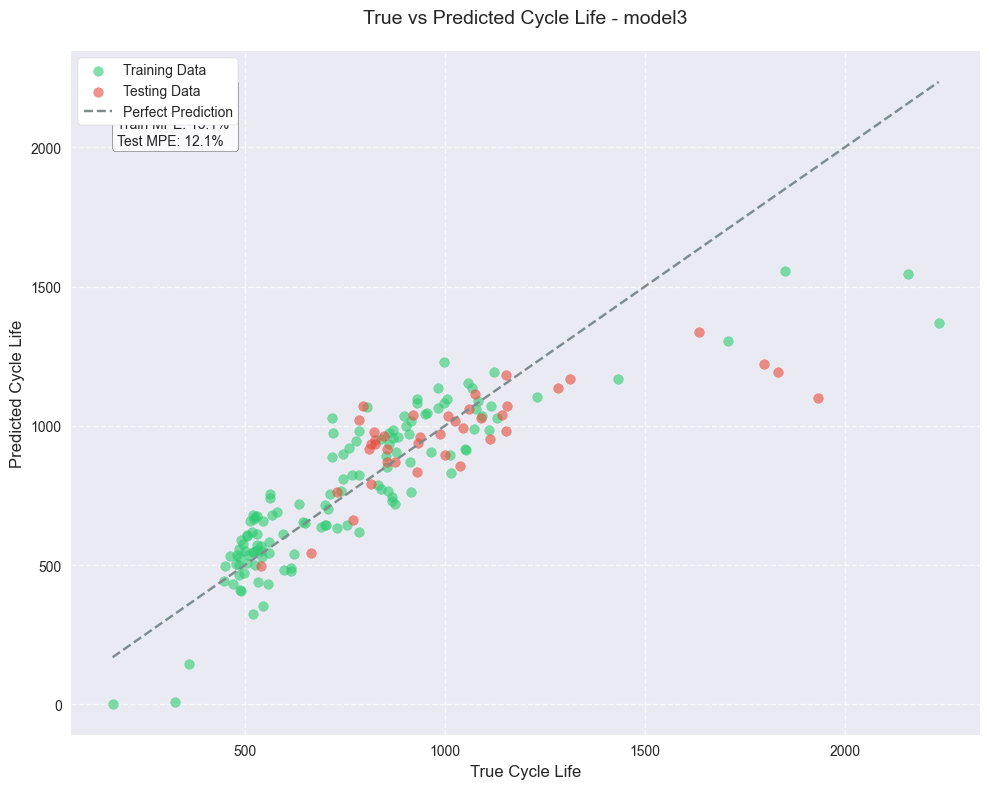

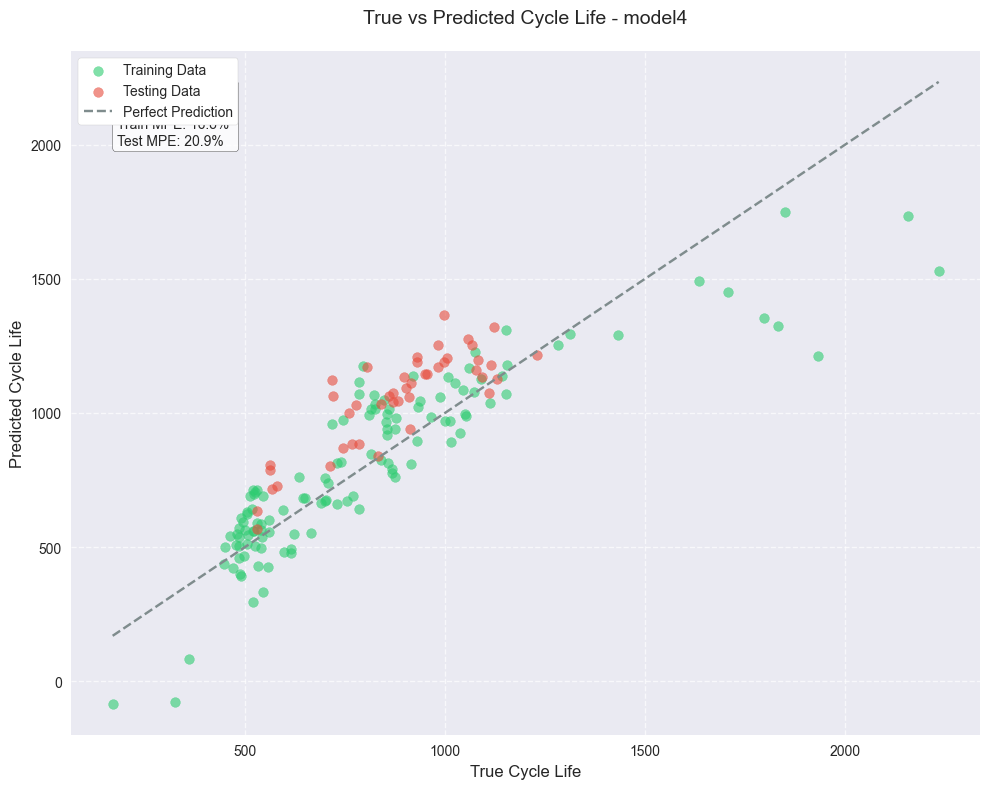

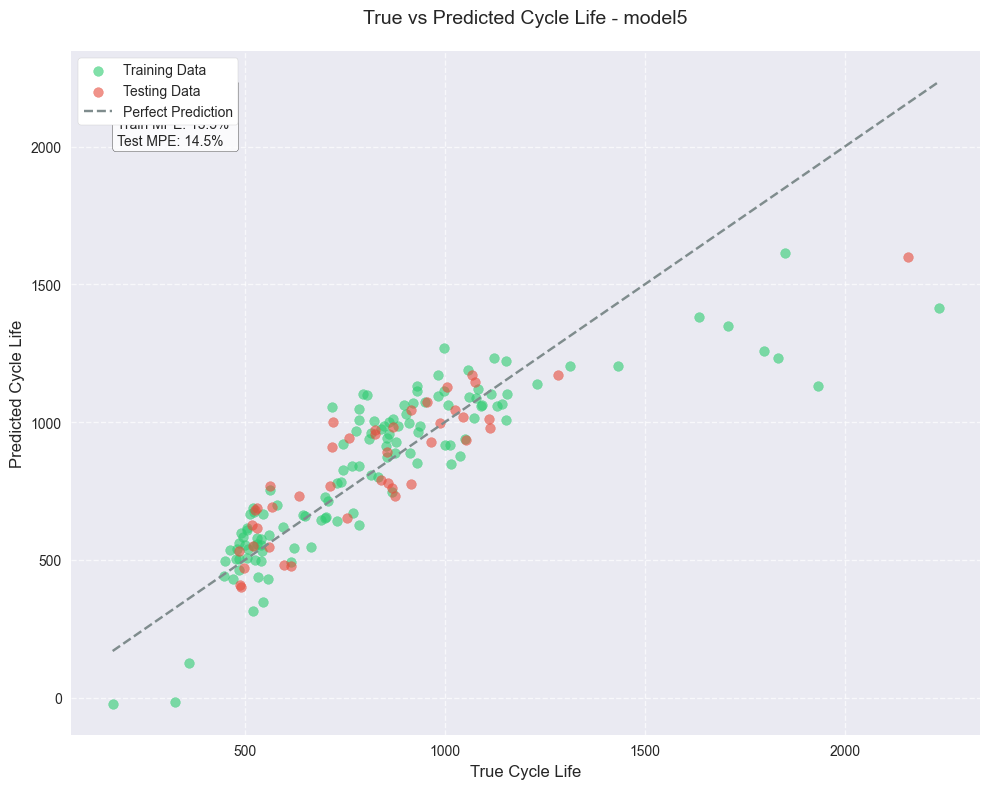

In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Optional

import matplotlib.pyplot as plt


def train_model_with_split(df, train_cells, test_cells):
    """Train model with specific train/test split and return predictions"""

    train_df = df[df["cell_key"].isin(train_cells)]
    test_df = df[df["cell_key"].isin(test_cells)]

    train_battery_data = convert_df_to_battery_data(train_df)
    test_battery_data = convert_df_to_battery_data(test_df)

    feature_extractor = VarianceModelFeatureExtractor()

    train_features = []
    train_cycle_lives = []
    test_features = []
    test_cycle_lives = []

    for battery in train_battery_data:
        feature = feature_extractor.get_features(battery)
        if not torch.isnan(feature).any():
            train_features.append(feature)
            train_cycle_lives.append(battery.cycle_data[-1].cycle_number)

    for battery in test_battery_data:
        feature = feature_extractor.get_features(battery)
        if not torch.isnan(feature).any():
            test_features.append(feature)
            test_cycle_lives.append(battery.cycle_data[-1].cycle_number)

    X_train = torch.stack(train_features)
    y_train = torch.tensor(train_cycle_lives)
    X_test = torch.stack(test_features)
    y_test = torch.tensor(test_cycle_lives)

    model = LinearRegression()
    model.fit(X_train.numpy(), y_train.numpy())

    train_pred = model.predict(X_train.numpy())
    test_pred = model.predict(X_test.numpy())

    train_rmse = np.sqrt(np.mean((train_pred - y_train.numpy()) ** 2))
    test_rmse = np.sqrt(np.mean((test_pred - y_test.numpy()) ** 2))
    train_mpe = np.mean(np.abs(train_pred - y_train.numpy()) / y_train.numpy() * 100)
    test_mpe = np.mean(np.abs(test_pred - y_test.numpy()) / y_test.numpy() * 100)
    train_mape = mean_absolute_percentage_error(y_train, train_pred) * 100
    test_mape = mean_absolute_percentage_error(y_train, test_pred) * 100

    return {
        "model": model,
        "metrics": {
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
            "train_mpe": train_mpe,
            "test_mpe": test_mpe,
            "train_mape": train_mape,
            "test_mape": test_mape,
        },
        "predictions": {
            "train_true": y_train.numpy(),
            "train_pred": train_pred,
            "test_true": y_test.numpy(),
            "test_pred": test_pred,
        },
    }


def plot_true_vs_predicted(results, model_name):
    """Create a scatter plot of true vs predicted cycle life"""
    plt.figure(figsize=(10, 8))

    plt.style.use("seaborn")

    plt.scatter(
        results["predictions"]["train_true"],
        results["predictions"]["train_pred"],
        alpha=0.6,
        label="Training Data",
        color="#2ecc71",
    )

    plt.scatter(
        results["predictions"]["test_true"],
        results["predictions"]["test_pred"],
        alpha=0.6,
        label="Testing Data",
        color="#e74c3c",
    )

    max_value = max(
        np.max(results["predictions"]["train_true"]), np.max(results["predictions"]["test_true"])
    )
    min_value = min(
        np.min(results["predictions"]["train_true"]), np.min(results["predictions"]["test_true"])
    )
    plt.plot(
        [min_value, max_value],
        [min_value, max_value],
        "--",
        color="#7f8c8d",
        label="Perfect Prediction",
    )

    plt.xlabel("True Cycle Life", fontsize=12)
    plt.ylabel("Predicted Cycle Life", fontsize=12)
    plt.title(f"True vs Predicted Cycle Life - {model_name}", fontsize=14, pad=20)

    metrics_text = f"Train RMSE: {results['metrics']['train_rmse']:.1f}\n"
    metrics_text += f"Test RMSE: {results['metrics']['test_rmse']:.1f}\n"
    metrics_text += f"Train MPE: {results['metrics']['train_mpe']:.1f}%\n"
    metrics_text += f"Test MPE: {results['metrics']['test_mpe']:.1f}%"

    plt.text(
        0.05,
        0.95,
        metrics_text,
        transform=plt.gca().transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

    plt.legend(frameon=True, facecolor="white", framealpha=1)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()

    return plt.gcf()


def main():
    df = load_and_merge_data()

    splits = get_cell_splits()

    results = {}
    figures = []
    for model_name, split in splits.items():
        print(f"\nTraining {model_name}...")
        model_results = train_model_with_split(df, split["train"], split["test"])
        results[model_name] = model_results

        fig = plot_true_vs_predicted(model_results, model_name)
        figures.append(fig)

        print(f"Train RMSE: {model_results['metrics']['train_rmse']:.1f} cycles")
        print(f"Train MPE: {model_results['metrics']['train_mpe']:.1f}%")
        print(f"Test RMSE: {model_results['metrics']['test_rmse']:.1f} cycles")
        print(f"Test MPE: {model_results['metrics']['test_mpe']:.1f}%")

    plt.show()
    return results, figures


if __name__ == "__main__":
    main()

# PCA & TSNE on variance features

Extracting features: variance_log10, max_first_discharge, max_last_discharge, capacity_retention, avg_middle_temp, discharge_time
Extracted features for 128 batteries
Explained variance ratio: [0.43237126 0.23534844]
Total explained variance: 66.77%

Feature loadings:
variance_log10: PC1 = 0.2608, PC2 = -0.5867
max_first_discharge: PC1 = 0.4647, PC2 = -0.2738
max_last_discharge: PC1 = 0.5784, PC2 = 0.2132
capacity_retention: PC1 = 0.5684, PC2 = 0.2366
avg_middle_temp: PC1 = 0.0076, PC2 = 0.6887
discharge_time: PC1 = -0.2415, PC2 = -0.0712


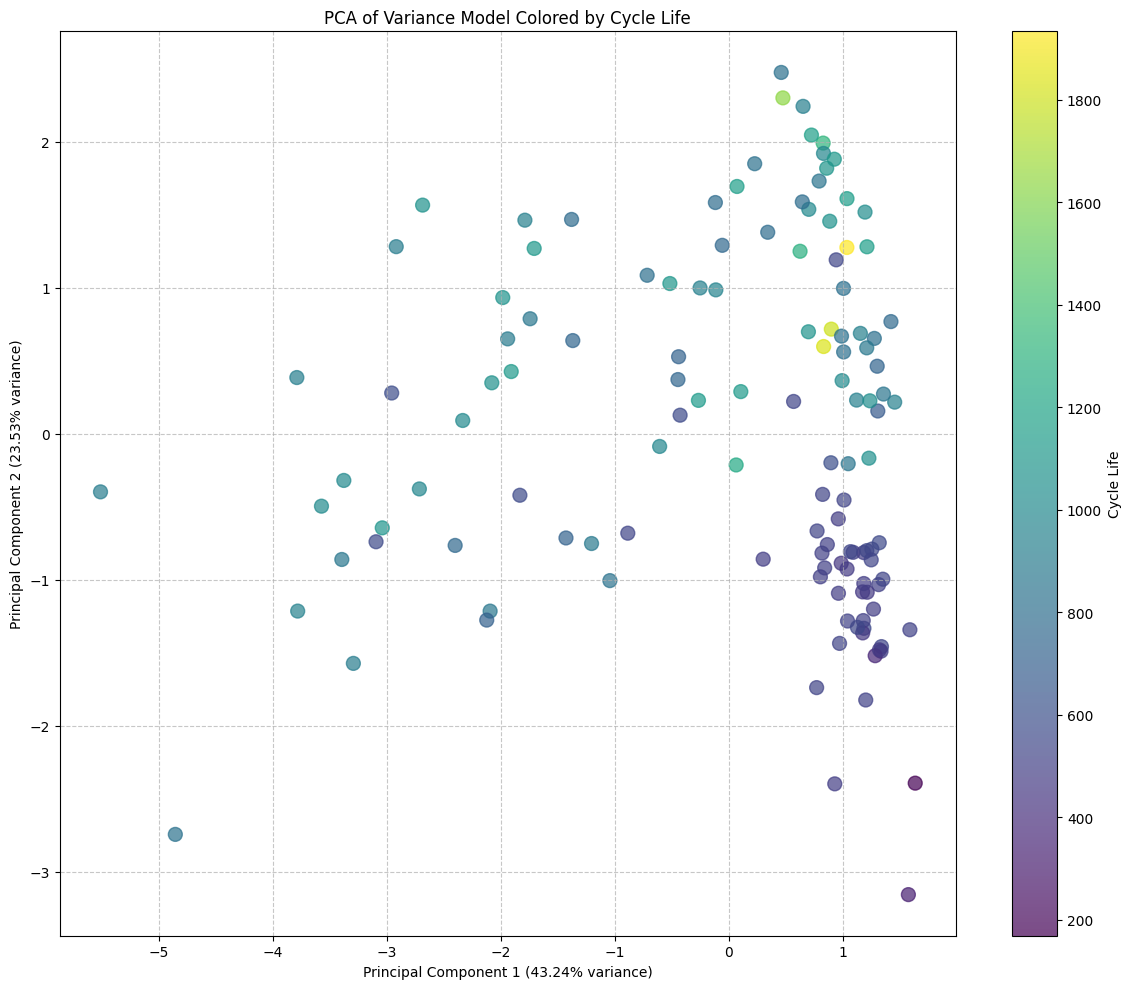

In [8]:
from sklearn.decomposition import PCA


def create_battery_feature_pca():
    """
    Create a PCA visualization of battery features colored by cycle life.
    """
    # Load data
    df = load_and_merge_data()

    # Convert to BatteryData objects
    battery_data_list = convert_df_to_battery_data(df)

    # Extract multiple features
    features, cycle_lives, cell_ids = extract_multiple_features(battery_data_list)

    if len(features) == 0:
        print("No valid features extracted. Check the data and feature extraction.")
        return None, None

    # Create visualization
    return visualize_pca(features, cycle_lives, cell_ids)


def extract_multiple_features(battery_data_list):
    """
    Extract multiple features from battery data for PCA visualization.
    """
    features_list = []
    cycle_lives = []
    cell_ids = []

    feature_names = [
        "variance_log10",
        "max_first_discharge",
        "max_last_discharge",
        "capacity_retention",
        "avg_middle_temp",
        "discharge_time",
    ]

    print(f"Extracting features: {', '.join(feature_names)}")

    for battery in battery_data_list:
        # Make sure we have enough cycles
        if len(battery.cycle_data) < 3:
            continue

        # Get the variance feature using the existing extractor
        variance_extractor = VarianceModelFeatureExtractor()
        variance_feature = variance_extractor.get_features(battery)

        # Skip if the variance feature is invalid
        if torch.isnan(variance_feature).any():
            continue

        # Find the first, middle, and last cycles
        first_cycle = battery.cycle_data[0]
        middle_idx = len(battery.cycle_data) // 2
        middle_cycle = battery.cycle_data[middle_idx]
        last_cycle = battery.cycle_data[-1]

        # Check for empty data in cycles
        if (
            len(first_cycle.discharge_capacity_in_Ah) == 0
            or len(middle_cycle.temperature_in_C) == 0
            or len(last_cycle.time_in_s) == 0
        ):
            continue

        # Initialize feature vector with the variance feature
        battery_features = [variance_feature.item()]

        # Feature 2: Maximum discharge capacity in first cycle
        max_first_discharge = max(first_cycle.discharge_capacity_in_Ah)

        # Avoid division by zero
        if max_first_discharge <= 0:
            continue

        battery_features.append(max_first_discharge)

        # Feature 3: Maximum discharge capacity in last cycle
        max_last_discharge = max(last_cycle.discharge_capacity_in_Ah)
        battery_features.append(max_last_discharge)

        # Feature 4: Capacity retention (last / first)
        cap_retention = max_last_discharge / max_first_discharge
        battery_features.append(cap_retention)

        # Feature 5: Average temperature in middle cycle
        if len(middle_cycle.temperature_in_C) > 0:
            avg_temp = sum(middle_cycle.temperature_in_C) / len(middle_cycle.temperature_in_C)
            battery_features.append(avg_temp)
        else:
            continue

        # Feature 6: Time to discharge in last cycle (max time - min time)
        if len(last_cycle.time_in_s) > 0:
            discharge_time = max(last_cycle.time_in_s) - min(last_cycle.time_in_s)
            battery_features.append(discharge_time)
        else:
            continue

        # Add to features list
        features_list.append(battery_features)
        cycle_lives.append(last_cycle.cycle_number)
        cell_ids.append(battery.cell_id)

    print(f"Extracted features for {len(features_list)} batteries")

    return np.array(features_list), cycle_lives, cell_ids


def visualize_pca(features, cycle_lives, cell_ids):
    """
    Apply PCA to features and create a visualization colored by cycle life.
    """
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features_scaled)

    # Create DataFrame with results
    pca_df = pd.DataFrame({
        "PC1": pca_result[:, 0],
        "PC2": pca_result[:, 1],
        "cell_id": cell_ids,
        "cycle_life": cycle_lives,
    })

    # Create visualization
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        pca_df["PC1"], pca_df["PC2"], c=pca_df["cycle_life"], cmap="viridis", alpha=0.7, s=100
    )

    plt.colorbar(scatter, label="Cycle Life")
    plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
    plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
    plt.title("PCA of Variance Model Colored by Cycle Life")

    # Add cell IDs as annotations (but not too many to avoid clutter)
    if len(cell_ids) <= 50:  # Only annotate if there aren't too many points
        for i, cell_id in enumerate(cell_ids):
            plt.annotate(cell_id, (pca_result[i, 0], pca_result[i, 1]), fontsize=8)

    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.7)

    # Print explained variance
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

    # Show feature loadings
    feature_names = [
        "variance_log10",
        "max_first_discharge",
        "max_last_discharge",
        "capacity_retention",
        "avg_middle_temp",
        "discharge_time",
    ]

    print("\nFeature loadings:")
    for i, feature in enumerate(feature_names):
        print(f"{feature}: PC1 = {pca.components_[0, i]:.4f}, PC2 = {pca.components_[1, i]:.4f}")

    return plt, pca_df


# Run the PCA visualization
plt, pca_df = create_battery_feature_pca()

Loading and processing data...
Extracting features: variance_log10, max_first_discharge, max_last_discharge, capacity_retention, avg_middle_temp, discharge_time
Extracted features for 128 batteries

--- t-SNE Visualizations ---

Running t-SNE with perplexity=5


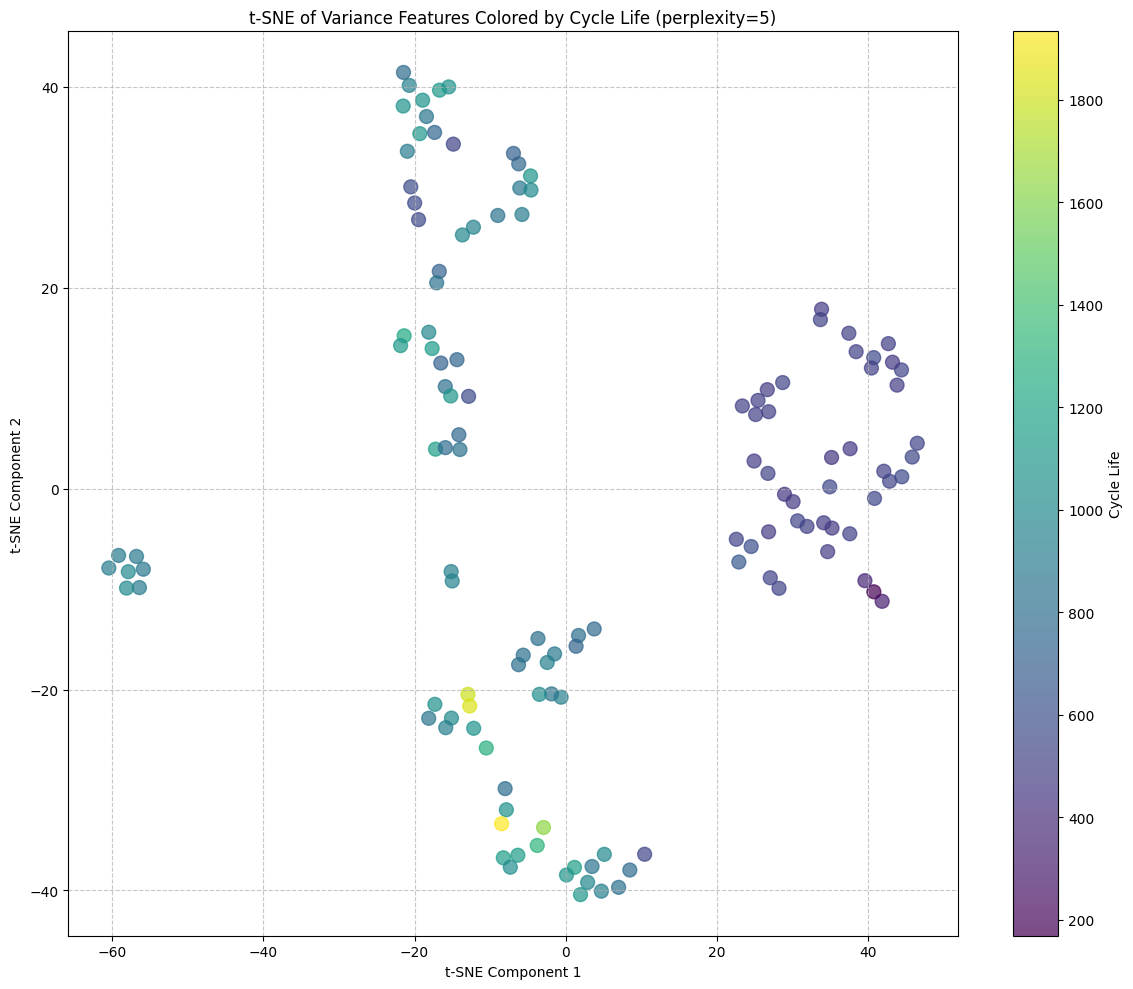


Running t-SNE with perplexity=30


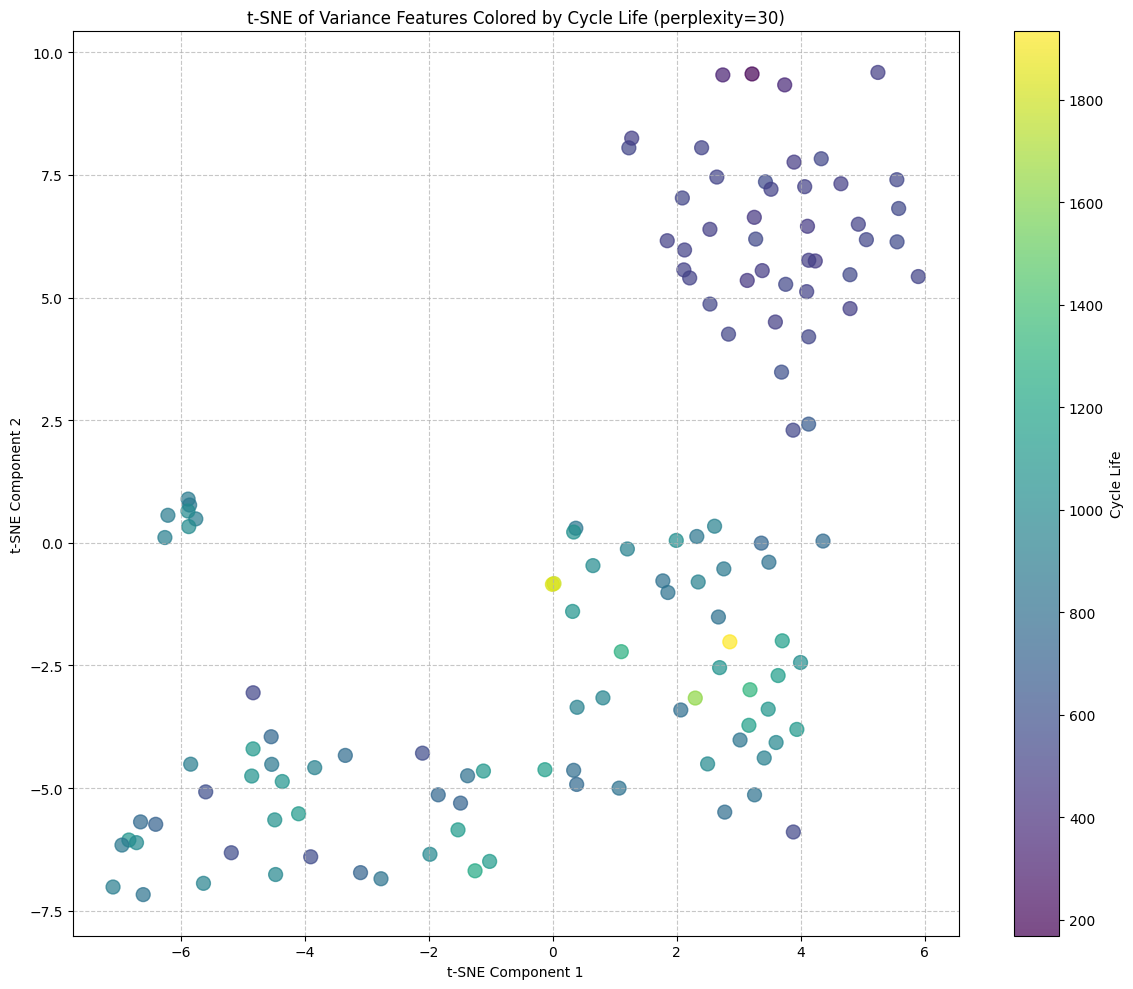


Running t-SNE with perplexity=50


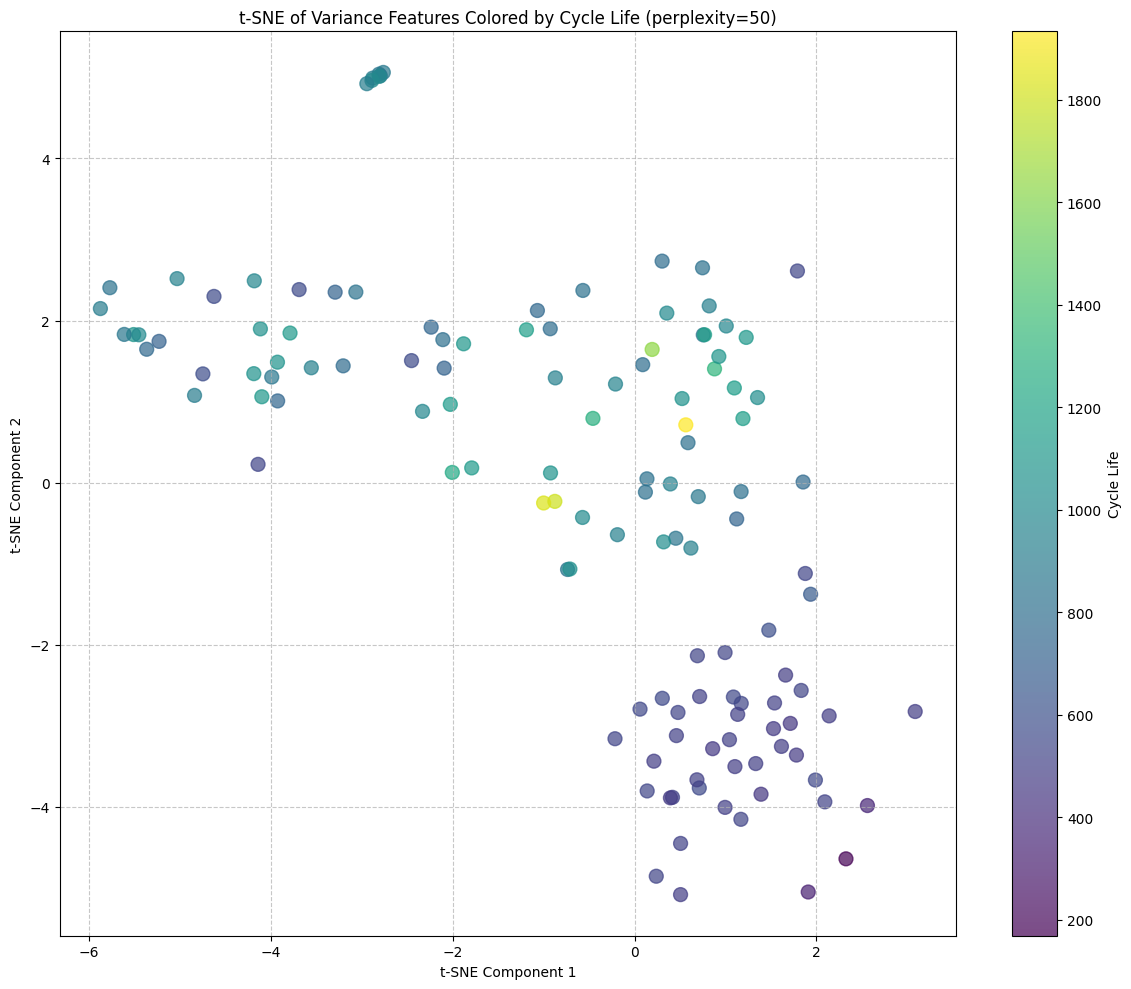


Running t-SNE with perplexity=100


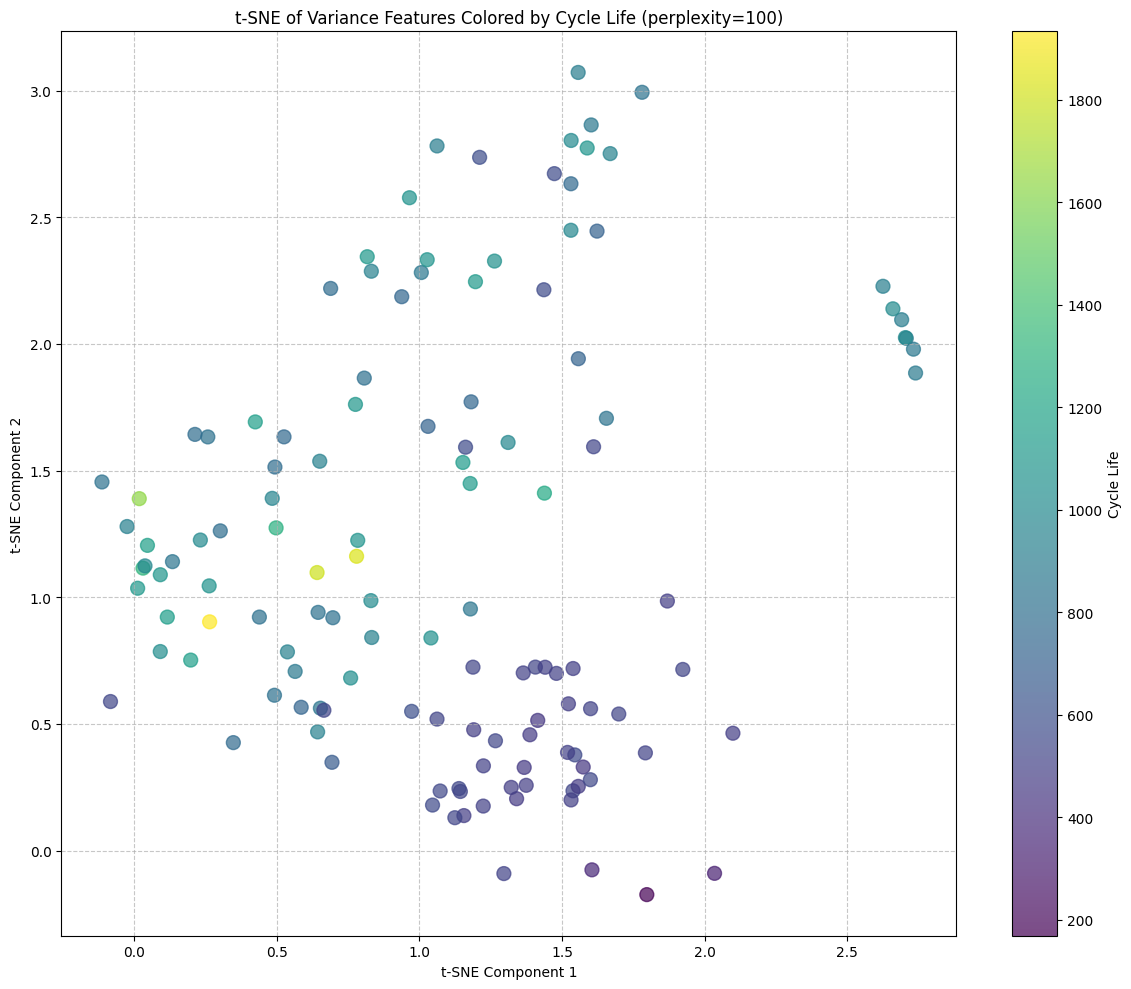


Running t-SNE with perplexity=200


ValueError: perplexity must be less than n_samples

In [7]:
from dataclasses import dataclass
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualize_pca(features, cycle_lives, cell_ids):
    """
    Apply PCA to features and create a visualization colored by cycle life.
    """
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features_scaled)

    # Create DataFrame with results
    pca_df = pd.DataFrame({
        "PC1": pca_result[:, 0],
        "PC2": pca_result[:, 1],
        "cell_id": cell_ids,
        "cycle_life": cycle_lives,
    })

    # Create visualization
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        pca_df["PC1"], pca_df["PC2"], c=pca_df["cycle_life"], cmap="viridis", alpha=0.7, s=100
    )

    plt.colorbar(scatter, label="Cycle Life")
    plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
    plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
    plt.title("PCA of Battery Features Colored by Cycle Life")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Print explained variance
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

    # Print feature loadings
    feature_names = [
        "variance_log10",
        "max_first_discharge",
        "max_last_discharge",
        "capacity_retention",
        "avg_middle_temp",
        "discharge_time",
    ]

    print("\nFeature loadings:")
    for i, feature in enumerate(feature_names):
        print(f"{feature}: PC1 = {pca.components_[0, i]:.4f}, PC2 = {pca.components_[1, i]:.4f}")

    return plt, pca_df


def visualize_tsne(features, cycle_lives, cell_ids, perplexity=30):
    """
    Apply t-SNE to features and create a visualization colored by cycle life.
    """
    # Standardize features (same as with PCA)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_result = tsne.fit_transform(features_scaled)

    # Create DataFrame with results
    tsne_df = pd.DataFrame({
        "TSNE1": tsne_result[:, 0],
        "TSNE2": tsne_result[:, 1],
        "cell_id": cell_ids,
        "cycle_life": cycle_lives,
    })

    # Create visualization
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        tsne_df["TSNE1"],
        tsne_df["TSNE2"],
        c=tsne_df["cycle_life"],
        cmap="viridis",
        alpha=0.7,
        s=100,
    )

    plt.colorbar(scatter, label="Cycle Life")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(f"t-SNE of Variance Features Colored by Cycle Life (perplexity={perplexity})")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()

    return plt, tsne_df


def run_visualizations():
    """
    Run both PCA and t-SNE visualizations on battery features.
    """
    # Load and process data
    print("Loading and processing data...")
    df = load_and_merge_data()
    battery_data_list = convert_df_to_battery_data(df)

    # Extract features
    features, cycle_lives, cell_ids = extract_multiple_features(battery_data_list)

    if len(features) == 0:
        print("No valid features extracted. Check the data and feature extraction.")
        return

    # Run PCA
    # print("\n--- PCA Visualization ---")
    # pca_plt, pca_df = visualize_pca(features, cycle_lives, cell_ids)
    # pca_plt.savefig('battery_pca.png')
    # pca_plt.show()

    # Run t-SNE with different perplexity values
    perplexity_values = [5, 30, 50, 100, 200]

    print("\n--- t-SNE Visualizations ---")
    for perplexity in perplexity_values:
        print(f"\nRunning t-SNE with perplexity={perplexity}")
        tsne_plt, tsne_df = visualize_tsne(features, cycle_lives, cell_ids, perplexity)
        tsne_plt.savefig(f"battery_tsne_perplexity_{perplexity}.png")
        tsne_plt.show()

    print("\nAll visualizations completed!")


if __name__ == "__main__":
    run_visualizations()

# Variance Model on NCA NCM dataset

In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Optional


@dataclass
class CycleData:
    cycle_number: int
    voltage_in_V: List[float]
    current_in_A: List[float]
    charge_capacity_in_Ah: List[float]
    discharge_capacity_in_Ah: List[float]
    time_in_s: List[float]
    temperature_in_C: List[float]
    internal_resistance_in_ohm: Optional[float] = None
    additional_data: Dict = None


class BatteryData:
    def __init__(self, cell_id, cycle_data, max_voltage_limit_in_V, min_voltage_limit_in_V):
        self.cell_id = cell_id
        self.cycle_data = cycle_data
        self.max_voltage_limit_in_V = max_voltage_limit_in_V
        self.min_voltage_limit_in_V = min_voltage_limit_in_V


class VarianceModelFeatureExtractor:
    def __init__(self, critical_cycles=None):
        self.critical_cycles = critical_cycles or [1, 9, 99]
        self.interp_dims = 1000
        self.smooth_diff_qdlin = True
        self.use_precalculated_qdlin = False

    def get_Qdlin(self, cell_data, cycle_data):
        eps = 1e-1
        I = np.array(cycle_data.current_in_A)
        V = np.array(cycle_data.voltage_in_V)
        Q = np.array(cycle_data.discharge_capacity_in_Ah)

        mask = I < -eps
        if sum(mask) <= 2:
            return np.zeros(1000)

        # Interpolate
        from scipy.interpolate import interp1d

        func = interp1d(V[mask], Q[mask], bounds_error=False)
        new_x = np.linspace(
            cell_data.min_voltage_limit_in_V, cell_data.max_voltage_limit_in_V, 1000
        )
        return func(new_x)[::-1]

    def get_features(self, cell_data):
        # Check if cell has all required cycles
        if len(cell_data.cycle_data) <= self.critical_cycles[2]:
            # Return default value if not enough cycles
            return torch.tensor([0.0])

        early_cycle = cell_data.cycle_data[self.critical_cycles[1]]
        late_cycle = cell_data.cycle_data[self.critical_cycles[2]]

        early_qdlin = self.get_Qdlin(cell_data, early_cycle)
        late_qdlin = self.get_Qdlin(cell_data, late_cycle)

        diff_qdlin = late_qdlin - early_qdlin
        diff_qdlin = torch.from_numpy(diff_qdlin)
        diff_qdlin = diff_qdlin[~diff_qdlin.isnan()]

        if len(diff_qdlin) <= 1:
            return torch.tensor([0.0])

        eps = 1e-8
        variance = (diff_qdlin.var() + eps).log10()

        return variance.unsqueeze(0)


def convert_df_to_battery_data(df):
    battery_data_list = []

    for cell_key, cell_df in df.groupby("cell_key"):
        cycle_data_list = []

        for _, cycle_group in cell_df.groupby("cycle_number"):
            cycle_data = CycleData(
                cycle_number=int(cycle_group["cycle_number"].iloc[0]),
                voltage_in_V=cycle_group["voltage"].tolist(),
                current_in_A=cycle_group["current"].tolist(),
                charge_capacity_in_Ah=cycle_group["charge_capacity"].tolist(),
                discharge_capacity_in_Ah=cycle_group["discharge_capacity"].tolist(),
                time_in_s=cycle_group["time"].tolist(),
                temperature_in_C=cycle_group["temperature"].tolist(),
                additional_data={"Qdlin": None},
            )
            cycle_data_list.append(cycle_data)

        battery = BatteryData(
            cell_id=cell_key,
            cycle_data=cycle_data_list,
            max_voltage_limit_in_V=4.2,
            min_voltage_limit_in_V=2.0,
        )
        battery_data_list.append(battery)

    return battery_data_list


def train_model_with_split(df, train_cells, test_cells):
    """Train model with specific train/test split"""

    # Filter data based on cell IDs
    train_df = df[df["cell_key"].isin(train_cells)]
    test_df = df[df["cell_key"].isin(test_cells)]

    # Get max cycle count for each cell
    max_cycles_by_cell = df.groupby("cell_key")["cycle_number"].max()

    # Filter cells that have at least 100 cycles
    min_required_cycles = 100
    valid_train_cells = [
        cell
        for cell in train_cells
        if cell in max_cycles_by_cell.index and max_cycles_by_cell[cell] >= min_required_cycles
    ]
    valid_test_cells = [
        cell
        for cell in test_cells
        if cell in max_cycles_by_cell.index and max_cycles_by_cell[cell] >= min_required_cycles
    ]

    print(
        f"Training on {len(valid_train_cells)}/{len(train_cells)} cells that have at least {min_required_cycles} cycles"
    )
    print(
        f"Testing on {len(valid_test_cells)}/{len(test_cells)} cells that have at least {min_required_cycles} cycles"
    )

    # Filter data again based on valid cells
    train_df = df[df["cell_key"].isin(valid_train_cells)]
    test_df = df[df["cell_key"].isin(valid_test_cells)]

    # Convert to BatteryData objects
    train_battery_data = convert_df_to_battery_data(train_df)
    test_battery_data = convert_df_to_battery_data(test_df)

    # Extract features
    feature_extractor = VarianceModelFeatureExtractor()

    train_features = []
    train_cycle_lives = []
    test_features = []
    test_cycle_lives = []

    for battery in train_battery_data:
        feature = feature_extractor.get_features(battery)
        if not torch.isnan(feature).any():
            train_features.append(feature)
            train_cycle_lives.append(battery.cycle_data[-1].cycle_number)

    for battery in test_battery_data:
        feature = feature_extractor.get_features(battery)
        if not torch.isnan(feature).any():
            test_features.append(feature)
            test_cycle_lives.append(battery.cycle_data[-1].cycle_number)

    # Check if we have enough data
    if len(train_features) == 0 or len(test_features) == 0:
        print("Not enough data for training or testing after filtering.")
        return {
            "model": None,
            "metrics": {
                "train_rmse": float("nan"),
                "test_rmse": float("nan"),
                "train_mpe": float("nan"),
                "test_mpe": float("nan"),
                "train_mape": float("nan"),
                "test_mape": float("nan"),
            },
        }

    # Convert to tensors
    X_train = torch.stack(train_features)
    y_train = torch.tensor(train_cycle_lives)
    X_test = torch.stack(test_features)
    y_test = torch.tensor(test_cycle_lives)

    # Train model
    model = LinearRegression()
    model.fit(X_train.numpy(), y_train.numpy())

    # Calculate metrics
    train_pred = model.predict(X_train.numpy())
    test_pred = model.predict(X_test.numpy())

    train_rmse = np.sqrt(np.mean((train_pred - y_train.numpy()) ** 2))
    test_rmse = np.sqrt(np.mean((test_pred - y_test.numpy()) ** 2))
    train_mpe = np.mean(np.abs(train_pred - y_train.numpy()) / y_train.numpy() * 100)
    test_mpe = np.mean(np.abs(test_pred - y_test.numpy()) / y_test.numpy() * 100)
    train_mape = mean_absolute_percentage_error(y_train, train_pred) * 100
    test_mape = mean_absolute_percentage_error(y_test, test_pred) * 100

    return {
        "model": model,
        "metrics": {
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
            "train_mpe": train_mpe,
            "test_mpe": test_mpe,
            "train_mape": train_mape,
            "test_mape": test_mape,
        },
    }


def get_cell_splits():
    """Return the train/test splits for each model"""
    splits = {
        "ncancm": {
            "train": [
                "nca2505008",
                "nca4505015",
                "nca4505014",
                "nca4505028",
                "nca2505009",
                "nca4505016",
                "nca4505017",
                "nca2505019",
                "nca4505009",
                "nca4505013",
                "nca4505012",
                "nca4505008",
                "nca2505018",
                "nca4505010",
                "nca2510009",
                "nca2510008",
                "nca4505011",
                "nca2505001",
                "nca2505016",
                "nca4505006",
                "nca4505020",
                "nca2510005",
                "nca2510004",
                "nca4505021",
                "nca4505007",
                "nca2505017",
                "nca2505002",
                "nca2505015",
                "nca4505005",
                "nca4505023",
                "nca2510006",
                "nca2510007",
                "nca4505022",
                "nca4505004",
                "nca2505014",
                "nca2505003",
                "nca2505007",
                "nca2505010",
                "nca4505026",
                "nca2510003",
                "nca2510002",
                "nca3505001",
                "nca4505027",
                "nca4505001",
                "nca2505011",
                "nca2505006",
                "nca2505004",
                "nca2505013",
                "nca4505003",
                "nca4505025",
                "nca4505019",
                "nca3505003",
                "nca2510001",
                "nca3505002",
                "nca4505018",
                "nca4505024",
                "nca4505002",
                "nca2505012",
                "nca2505005",
                "nca2502503",
                "nca2502502",
                "nca2502501",
                "ncm2505008",
                "ncm2505023",
                "ncm4505015",
                "ncm4505014",
                "ncm4505028",
                "ncm2505022",
                "ncm2505009",
                "ncm2505020",
                "ncm4505016",
                "ncm4505017",
                "ncm2505021",
                "ncm2505019",
                "ncm4505009",
                "ncm4505013",
                "ncm4505012",
                "ncm4505008",
                "ncm2505018",
                "ncm4505010",
                "ncm4505011",
                "ncm2505001",
                "ncm2505016",
                "ncm4505006",
                "ncm4505020",
                "ncm4505021",
                "ncm4505007",
                "ncm2505017",
                "ncm2505002",
                "ncm2505015",
            ],
            "test": [
                "nca2502505",
                "nca2502504",
                "nca2502506",
                "nca2502507",
                "ncm4505005",
                "ncm4505023",
                "ncm3505004",
                "ncm4505022",
                "ncm4505004",
                "ncm2505014",
                "ncm2505003",
                "ncm2505007",
                "ncm2505010",
                "ncm4505026",
                "ncm3505001",
                "ncm4505027",
                "ncm4505001",
                "ncm2505011",
                "ncm2505006",
                "ncm2505004",
                "ncm2505013",
                "ncm4505003",
                "ncm4505025",
                "ncm4505019",
                "ncm3505003",
                "ncm3505002",
                "ncm4505018",
                "ncm4505024",
                "ncm4505002",
                "ncm2505012",
                "ncm2505005",
                "ncmca2505001",
                "ncmca2505003",
                "ncmca2505002",
            ],
        },
    }

    return splits


def main():
    # Load and merge data
    df = pd.read_csv("../nca_ncm_cycle_life.csv")

    # Get splits
    splits = get_cell_splits()

    # Train models for each split
    results = {}
    for model_name, split in splits.items():
        print(f"\nTraining {model_name}...")
        model_results = train_model_with_split(df, split["train"], split["test"])
        results[model_name] = model_results["metrics"]
        print(f"Train RMSE: {model_results['metrics']['train_rmse']:.1f} cycles")
        print(f"Train MPE: {model_results['metrics']['train_mpe']:.1f}%")
        print(f"Train MAPE: {model_results['metrics']['train_mape']:.1f}%")
        print(f"Test RMSE: {model_results['metrics']['test_rmse']:.1f} cycles")
        print(f"Test MPE: {model_results['metrics']['test_mpe']:.1f}%")
        print(f"Test MAPE: {model_results['metrics']['test_mape']:.1f}%")

    return results


if __name__ == "__main__":
    main()


Training ncancm...
Training on 80/90 cells that have at least 100 cycles
Testing on 33/34 cells that have at least 100 cycles
Train RMSE: 240.8 cycles
Train MPE: 73.4%
Train MAPE: 73.4%
Test RMSE: 409.7 cycles
Test MPE: 69.4%
Test MAPE: 69.4%
